In [1]:
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set()

/Users/travismcguire1/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
filename = 'train.csv' 
df = pd.read_csv(filename)
df.head()

/Users/travismcguire1/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


# Preprocess Data

## Fix Null Field Positions

In [3]:
print("Before")
field_positions = df['FieldPosition']
print(sum(field_positions.isnull()==True))
print(df.shape)
print(df[df.FieldPosition.isnull()][['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine']].head())

# Handle 50 YardLine by filling in the null 'FieldPositions' with the value in 'PossessionTeam'
df.FieldPosition.fillna(df.PossessionTeam, inplace=True)

print("After")
field_positions = df['FieldPosition']
print(sum(field_positions.isnull()==True))
print(df.shape)
print(df[198:203][['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine']])

Before
6424
(509762, 49)
         GameId          PlayId FieldPosition PossessionTeam  YardLine
198  2017090700  20170907000801           NaN             KC        50
199  2017090700  20170907000801           NaN             KC        50
200  2017090700  20170907000801           NaN             KC        50
201  2017090700  20170907000801           NaN             KC        50
202  2017090700  20170907000801           NaN             KC        50
After
0
(509762, 49)
         GameId          PlayId FieldPosition PossessionTeam  YardLine
198  2017090700  20170907000801            KC             KC        50
199  2017090700  20170907000801            KC             KC        50
200  2017090700  20170907000801            KC             KC        50
201  2017090700  20170907000801            KC             KC        50
202  2017090700  20170907000801            KC             KC        50


## Downsample, keep only entries where players is rusher

In [4]:
print("Before")
print(df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards']])
print(df.shape)

# Only keep entries associated with rusher
df = df[df['NflIdRusher']==df['NflId']]
df.reset_index(drop=True, inplace=True)

print("After")
print(df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards']])
print(df.shape)

Before
       GameId          PlayId FieldPosition PossessionTeam  YardLine  Yards
0  2017090700  20170907000118            NE             NE        35      8
1  2017090700  20170907000118            NE             NE        35      8
2  2017090700  20170907000118            NE             NE        35      8
3  2017090700  20170907000118            NE             NE        35      8
4  2017090700  20170907000118            NE             NE        35      8
(509762, 49)
After
       GameId          PlayId FieldPosition PossessionTeam  YardLine  Yards
0  2017090700  20170907000118            NE             NE        35      8
1  2017090700  20170907000139            NE             NE        43      3
2  2017090700  20170907000189            KC             NE        35      5
3  2017090700  20170907000345            KC             NE         2      2
4  2017090700  20170907000395            KC             KC        25      7
(23171, 49)


## Calculate yards remaining (new feature)

In [5]:
df['YardsRemaining'] = 100 - df.YardLine[df.FieldPosition == df.PossessionTeam]
df.YardsRemaining.fillna(df.YardLine, inplace=True)
df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards', 'YardsRemaining']]

,GameId,PlayId,FieldPosition,PossessionTeam,YardLine,Yards,YardsRemaining
0,2017090700,20170907000118,NE,NE,35,8,65.0
1,2017090700,20170907000139,NE,NE,43,3,57.0
2,2017090700,20170907000189,KC,NE,35,5,35.0
3,2017090700,20170907000345,KC,NE,2,2,2.0
4,2017090700,20170907000395,KC,KC,25,7,75.0


## Fix Defenders In Box Feature

Before
1 in Box Count: 1
2 in Box Count: 1
NaN in Box Count: 3
After
1 in Box Count: 0
2 in Box Count: 0
NaN in Box Count: 0


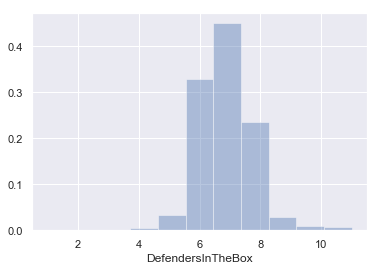

In [6]:
print("Before")
print("1 in Box Count:", len(df[df.DefendersInTheBox==1]))
print("2 in Box Count:", len(df[df.DefendersInTheBox==2]))
print("NaN in Box Count:", sum(df.DefendersInTheBox.isnull()))
sns.distplot(df.DefendersInTheBox[df.DefendersInTheBox.isnull()==False], bins=11, kde=False, norm_hist=True)

# Fill nan with median (i.e. 7), and bump 1 or 2 (few samples) up to 3
df.DefendersInTheBox.fillna(7, inplace=True)
df.DefendersInTheBox.replace(to_replace=[1, 2], value=3, inplace=True)

print("After")
print("1 in Box Count:", len(df[df.DefendersInTheBox==1]))
print("2 in Box Count:", len(df[df.DefendersInTheBox==2]))
print("NaN in Box Count:", sum(df.DefendersInTheBox.isnull()))

## Fix Position Feature

Before 

Position
CB        9
DE        1
DT        2
FB      169
HB      616
QB       77
RB    21628
TE       31
WR      638
dtype: int64

 After
Position
FB         169
HB         616
Other       12
QB          77
RB       21628
TE          31
WR         638
dtype: int64


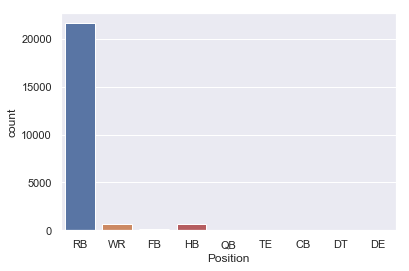

In [7]:
print("Before \n")
print(df.groupby(['Position']).size())
sns.countplot(x="Position", data=df)

# Change 'CB', 'DE', 'DT' (few samples) to 'Other'
df.Position.replace(to_replace=['CB', 'DE', 'DT'], value='Other', inplace=True)

print("\n After")
print(df.groupby(['Position']).size())

## Calculate number of carries (new feature)

In [8]:
carries = df[['PlayId', 'NflIdRusher', 'DisplayName']].groupby(['DisplayName', 'NflIdRusher']).agg('count').reset_index()
carries.rename(columns={'PlayId':'Carries'}, inplace=True)
print(carries.sort_values(by='Carries'))
print(sum(carries['Carries']>=10))

         DisplayName  NflIdRusher  Carries
372        Zay Jones      2557863        1
94   Darren McFadden          284        1
216      Keith Smith      2550400        1
92   Darius Jennings      2553896        1
90      Dante Pettis      2560836        1
..               ...          ...      ...
213      Kareem Hunt      2557917      450
260    Melvin Gordon      2552469      455
192    Jordan Howard      2555418      518
346      Todd Gurley      2552475      533
140  Ezekiel Elliott      2555224      537

[373 rows x 3 columns]
158


In [9]:
df = df.merge(carries[['NflIdRusher', 'Carries']], how = 'left', on = 'NflIdRusher')
df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards', 'YardsRemaining', 'NflIdRusher', 'DisplayName', 'Carries']]

,GameId,PlayId,FieldPosition,PossessionTeam,YardLine,Yards,YardsRemaining,NflIdRusher,DisplayName,Carries
0,2017090700,20170907000118,NE,NE,35,8,65.0,2543773,James White,135
1,2017090700,20170907000139,NE,NE,43,3,57.0,2543773,James White,135
2,2017090700,20170907000189,KC,NE,35,5,35.0,2543773,James White,135
3,2017090700,20170907000345,KC,NE,2,2,2.0,2539663,Mike Gillislee,120
4,2017090700,20170907000395,KC,KC,25,7,75.0,2557917,Kareem Hunt,450


In [10]:
player_yards = df[['Yards', 'NflIdRusher', 'DisplayName']].groupby(['DisplayName', 'NflIdRusher']).agg(['mean', 'max', 'min'])['Yards'].reset_index()
player_yards.rename(columns={'mean':'RusherMeanYards', 'max':'RusherMaxYards', 'min':'RusherMinYards'}, inplace=True)
player_yards.head()

,DisplayName,NflIdRusher,RusherMeanYards,RusherMaxYards,RusherMinYards
0,Aaron Jones,2558116,5.533019,67,-5
1,Aaron Ripkowski,2552477,2.600000,4,1
2,Adam Humphries,2553895,6.500000,7,6
3,Adam Thielen,2541785,6.833333,15,-1
4,Adoree' Jackson,2558065,11.000000,20,-3


In [11]:
df = df.merge(player_yards[['NflIdRusher', 'RusherMeanYards', 'RusherMaxYards', 'RusherMinYards']], how = 'left', on = 'NflIdRusher')
df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards', 'YardsRemaining', 'NflIdRusher', 'DisplayName', 'Carries', 'RusherMeanYards', 'RusherMaxYards', 'RusherMinYards']]

,GameId,PlayId,FieldPosition,PossessionTeam,YardLine,Yards,YardsRemaining,NflIdRusher,DisplayName,Carries,RusherMeanYards,RusherMaxYards,RusherMinYards
0,2017090700,20170907000118,NE,NE,35,8,65.0,2543773,James White,135,4.385185,27,-6
1,2017090700,20170907000139,NE,NE,43,3,57.0,2543773,James White,135,4.385185,27,-6
2,2017090700,20170907000189,KC,NE,35,5,35.0,2543773,James White,135,4.385185,27,-6
3,2017090700,20170907000345,KC,NE,2,2,2.0,2539663,Mike Gillislee,120,3.550000,16,-4
4,2017090700,20170907000395,KC,KC,25,7,75.0,2557917,Kareem Hunt,450,4.728889,69,-6


# Train and Dev Split

In [12]:
train, dev = train_test_split(df, test_size=0.3, random_state=1, shuffle=True)
print(train.shape)
print(dev.shape)

(16253, 54)
(6966, 54)


# Perform MLE

## Calculate CDF with all data

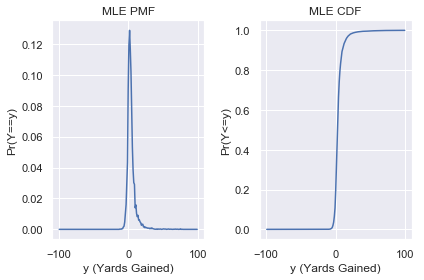

In [47]:
# calculate pmf 
yard_counts = np.zeros((199), dtype = 'double')
for yard in range(-99, 100):
    yard_counts[yard+99] = sum(train['Yards']==yard)
yard_probabilities = yard_counts / np.sum(yard_counts)

# calculate cdf
yard_cdf = np.cumsum(yard_probabilities)

fig, axes = plt.subplots(1, 2)
axes[0].plot(np.arange(-99,100), yard_probabilities)
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y==y)', title='MLE PMF')
axes[1].plot(np.arange(-99,100), yard_cdf)
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='MLE CDF')
plt.tight_layout()

## Squashing probabilities 

In [48]:
# squash probabilities
def squash(yard_cdf, yard_remaining):
    squash_cdf = yard_cdf.copy()
    squash_cdf[199-(100 - yard_remaining):] = 1
    squash_cdf[0:yard_remaining-1] = 0 
    return squash_cdf

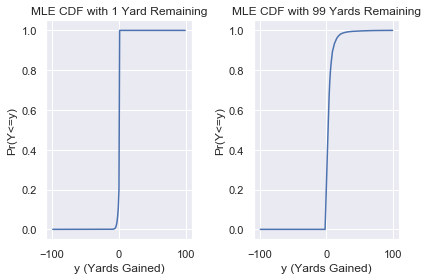

In [49]:
one_cdf = squash(yard_cdf, 1)
ninenine_cdf = squash(yard_cdf, 99)

fig, axes = plt.subplots(1, 2)
axes[0].plot(np.arange(-99,100), one_cdf)
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='MLE CDF with 1 Yard Remaining')
axes[1].plot(np.arange(-99,100), ninenine_cdf)
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='MLE CDF with 99 Yards Remaining')
plt.tight_layout()

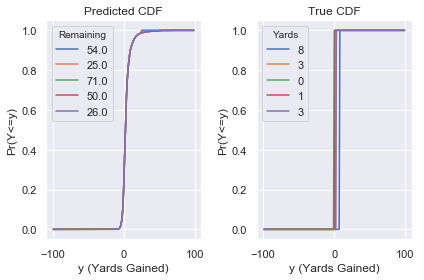

In [74]:
fig, axes = plt.subplots(1, 2)

for index, row in dev.head().iterrows():
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    axes[0].plot(np.arange(-99,100), pred_cdf, label=row['YardsRemaining'])
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    axes[1].plot(np.arange(-99,100), true_cdf, label=row['Yards'])

    
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='Predicted CDF')
axes[0].legend(title='Remaining')
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='True CDF')
axes[1].legend(title='Yards')
plt.tight_layout()

## Loss for model using all of the data

In [75]:
all_loss = []
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.014228038590878522


## Investigating loss/cost

(Cost, Yards Remaining)


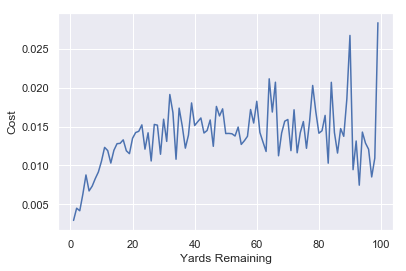

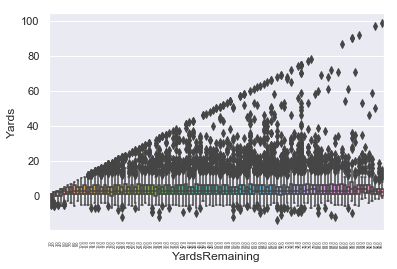

In [52]:
# dict to store [cumulative loss, # loss terms] for each yard_remaining
all_loss = {yard_remaining:[0, 0] for yard_remaining in range(1, 100)}
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss[int(row['YardsRemaining'])][0] += loss
    all_loss[int(row['YardsRemaining'])][1] += 1
cost = {k:v[0]/v[1] for k, v in all_loss.items()}
print("(Cost, Yards Remaining)")
sorted(((v,k) for k,v in cost.items()), reverse=True)

# Make plot, easier to interpret
sorted_yard_cost = sorted(((k,v) for k,v in cost.items()))
sorted_cost = []
for yards_remaining, avg_loss in sorted_yard_cost:
    sorted_cost.append(avg_loss)
plt.plot(np.arange(1,100), sorted_cost)
plt.xlabel('Yards Remaining')
plt.ylabel('Cost')
plt.figure()

ax = sns.boxplot(x="YardsRemaining", y="Yards", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=4);

In [53]:
# dict to store [cumulative loss, # loss terms] for each number of defenders in box
all_loss = {dib:[0, 0] for dib in range(3, 12)}
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss[int(row['DefendersInTheBox'])][0] += loss
    all_loss[int(row['DefendersInTheBox'])][1] += 1
cost = {k:v[0]/v[1] for k, v in all_loss.items()}
print("(Cost, Defenders In The Box)")
sorted(((v,k) for k,v in cost.items()), reverse=True)

(Cost, Defenders In The Box)


[(0.018117450627950046, 5),
 (0.01773227084572138, 4),
 (0.016025303784570205, 3),
 (0.01497115696082684, 9),
 (0.014538670941643853, 7),
 (0.014308610862836982, 6),
 (0.01351598199927049, 8),
 (0.0036544354227254, 11),
 (0.0035064331021326845, 10)]

In [54]:
# dict to store [cumulative loss, # loss terms] for each number of defenders in box
all_loss = {dib:[0, 0] for dib in df.Position.unique()}
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss[row['Position']][0] += loss
    all_loss[row['Position']][1] += 1
cost = {k:v[0]/v[1] for k, v in all_loss.items()}
print("(Cost, Position)")
sorted(((v,k) for k,v in cost.items()), reverse=True)

(Cost, Position)


[(0.024032196903946913, 'WR'),
 (0.02017833438630165, 'TE'),
 (0.019197712393171005, 'Other'),
 (0.017336820384854214, 'QB'),
 (0.014133422721999318, 'HB'),
 (0.013927071025892577, 'RB'),
 (0.009459706377450477, 'FB')]

## A new take on squashing

In [55]:
# squash probabilities
def squash_upper(cdf, squash_yard):
    squash_cdf = cdf.copy()
    squash_cdf[99+squash_yard:] = 1
    return squash_cdf

def squash_lower(cdf, squash_yard):
    squash_cdf = cdf.copy()
    squash_cdf[0:99+squash_yard] = 0
    return squash_cdf

In [56]:
all_loss = []
for index, row in dev.iterrows():
    if int(row['Carries']) > 10:
        pred_cdf = squash_upper(yard_cdf, int(row['RusherMaxYards']))
        pred_cdf = squash_lower(pred_cdf, int(row['RusherMinYards']))
    else:
        pred_cdf = yard_cdf.copy()
    pred_cdf = squash(pred_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.01422045019890437


## Laplace Smoothing

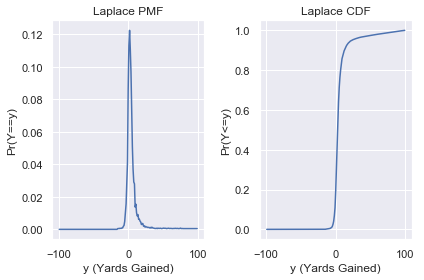

In [70]:
# calculate laplace pmf
total_count = sum(yard_counts)
lower = -15
upper = 100
n_smoothed = upper - lower
for yard in range(lower, upper):
    yard_counts[99+yard] += 1
yard_probabilities_laplace = yard_counts/(total_count+n_smoothed)

# calculate laplce cdf
yard_cdf_laplace = np.cumsum(yard_probabilities_laplace)

fig, axes = plt.subplots(1, 2)
axes[0].plot(np.arange(-99,100), yard_probabilities_laplace)
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y==y)', title='Laplace PMF')
axes[1].plot(np.arange(-99,100), yard_cdf_laplace)
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='Laplace CDF')
plt.tight_layout()

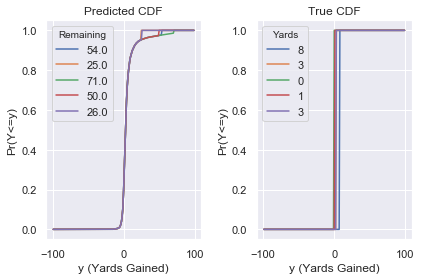

In [71]:
fig, axes = plt.subplots(1, 2)

for index, row in dev.head().iterrows():
    pred_cdf = squash(yard_cdf_laplace, int(row['YardsRemaining']))
    axes[0].plot(np.arange(-99,100), pred_cdf, label=row['YardsRemaining'])
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    axes[1].plot(np.arange(-99,100), true_cdf, label=row['Yards'])

    
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='Predicted CDF')
axes[0].legend(title='Remaining')
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='True CDF')
axes[1].legend(title='Yards')
plt.tight_layout()

In [73]:
all_loss = []
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf_laplace, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.014357044232222083


(Cost, Yards Remaining)


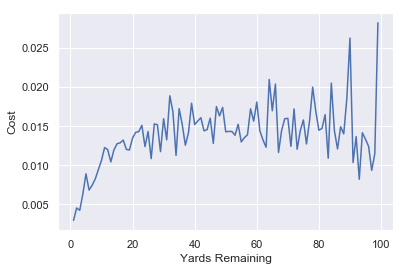

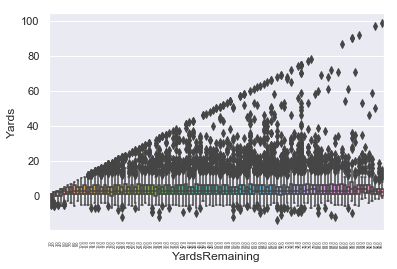

In [76]:
# dict to store [cumulative loss, # loss terms] for each yard_remaining
all_loss = {yard_remaining:[0, 0] for yard_remaining in range(1, 100)}
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf_laplace, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss[int(row['YardsRemaining'])][0] += loss
    all_loss[int(row['YardsRemaining'])][1] += 1
cost = {k:v[0]/v[1] for k, v in all_loss.items()}
print("(Cost, Yards Remaining)")
sorted(((v,k) for k,v in cost.items()), reverse=True)

# Make plot, easier to interpret
sorted_yard_cost = sorted(((k,v) for k,v in cost.items()))
sorted_cost = []
for yards_remaining, avg_loss in sorted_yard_cost:
    sorted_cost.append(avg_loss)
plt.plot(np.arange(1,100), sorted_cost)
plt.xlabel('Yards Remaining')
plt.ylabel('Cost')
plt.figure()

ax = sns.boxplot(x="YardsRemaining", y="Yards", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=4);

# Perform MLE Segmented by Yardline

## Find model for each yard line

In [43]:
yard_counts = np.zeros((99,199), dtype = 'uint32')
yard_probabilities = np.zeros((99,199), dtype = 'float')

for yard_remaining in range(1,100):
    yards_current = train.Yards[train['YardsRemaining']==yard_remaining]
    
    for yard in range(-99, 100):
        yard_counts[yard_remaining-1,yard+99] = sum(yards_current==yard)
        
    yard_probabilities[yard_remaining-1,:] = yard_counts[yard_remaining-1,:] / np.sum(yard_counts[yard_remaining-1,:])
    
# CDF 
yard_cdf = np.zeros(yard_probabilities.shape)
for yard_remaining in range(1, 100):
    yard_cdf[yard_remaining-1] = np.cumsum(yard_probabilities[yard_remaining-1,:])

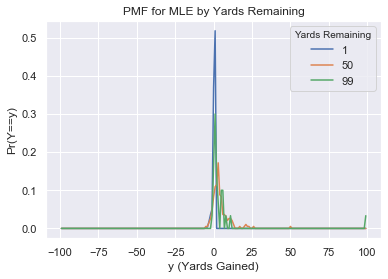

In [18]:
for yard_line in [1,50,99]:
    yard_line_index = yard_line -1
    plt.plot(np.arange(-99,100),yard_probabilities[yard_line_index,:], label = str(yard_line))
    
plt.title('PMF for MLE by Yards Remaining')
plt.ylabel('Pr(Y==y)')
plt.xlabel('y (Yards Gained)')
plt.legend(title='Yards Remaining');

In [19]:
all_loss = []
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf[int(row['YardsRemaining'])-1,:], int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.014088655099676866


# Boosted MLE by Yardline

## Using Gaussian kernel method to boost models for each yard line

In [20]:
#tune this as needed
sigma = 16
boosted_cdf = np.zeros(199)
weights = []
for true_remaining in range(1,100):
    for model_remaining in range (1,100):
        yard_line_cdf = yard_cdf[model_remaining-1,:]
        weight = np.exp(-((true_remaining - model_remaining)**2) / (2*(sigma**2)))
        weights.append(weight)
        boosted_cdf += weight*yard_line_cdf
        
#normalize the cdf
boosted_cdf /= np.sum(weights)  

## Compute loss for weighted model

In [21]:
all_loss = []
for index, row in dev.iterrows():
    pred_cdf = squash(boosted_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.014044888138695224
